# MPC - Nonlinear Dynamics using ODE
## Involve solving quadratic programs for the future time 

In [1]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
  !wget -O basic_material.py https://www.dropbox.com/s/3aoexl8vxyitmds/basic_material.py?dl=0
%run basic_material

from os import path
if os.path.isdir("./data/"):
    pass
else:
    !mkdir ./data
    
if os.path.isdir("./figs/"):
    pass
else:
    !mkdir ./figs

from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from numpy import linalg as LA
from scipy.linalg import expm

Running Python: 3.8.12


In [16]:
# cts time dynamics model
A = np.array([[0, 1], [-1, -0.01]]) # dynamics (cts)
Bu = np.array([0, 1])           # actuator input
Rzz = np.array([[10, 0],[0, 0.1]])   # performance variable penalty

In [17]:
N = 10 # MPC steps
Tf = 5
T0 = 0
Ts = (Tf-T0)/N

In [20]:
# ODE compute response to an input stream given by U
def fun_mpc(t,x,u):
    # dxdt = A@x + Bu*u(t)
    dxdt = np.array([x[1], -x[0]-0.1*x[0]**3 + u(t)])
    return dxdt

# NL Constraint
def cons_f(U):
    return LA.norm(U, np.inf) - 1

nonlinear_constraint = NonlinearConstraint(cons_f, -np.inf, 0) # inequality UB of zero

def cost(U, mpc_x0, Tf, N): # U will be array of future control inputs
    u = interp1d(x = t_plan, y = U, kind='zero')
    res1 = solve_ivp(fun_mpc, [0, Tf], mpc_x0, t_eval=t_plan, args=(u, ))
    z0 = res1.y[0] 
    z1 = res1.y[1] 
    delU = np.diff(U)
    J = Rzz[0,0]*np.dot(z0,z0) + Rzz[1,1]*np.dot(z1,z1) + np.dot(delU,delU)/10
    return J

In [22]:
Tfsim = 20
t_plan = np.linspace(0, Tf, N) # MPC plan time
delT_sim = Ts/2             # sim Ts
t_prop = np.array([0,delT_sim]) # prop time
Npts = Tfsim//delT_sim     # number of sim pts

U = [-1 for i in t_plan] 
Ustore = []

x0 = np.array([2, 2])       # IC for sim
X = x0
prev_time = time.time()
for k in np.arange(Npts):
    res = minimize(cost, np.append(U[1:],0), tol=1e-2, method = 'trust-constr', constraints=[nonlinear_constraint], args=(X,Tf,N))
    U = res.x
    uprop = interp1d(x = t_prop, y = U[0:2], kind='zero')
    prop = solve_ivp(fun_mpc, [0, delT_sim], X, t_eval=t_prop, args=(uprop, ))
    Ustore = np.append(Ustore,sat(U[0]))
    X = prop.y[:,-1]
    print(f'{k/Npts:.2f} ', end = '')
    print(f'{time.time() - prev_time:.2f} s')
    prev_time = time.time()

0.00 1.93 s
0.01 5.25 s
0.03 4.71 s
0.04 3.96 s
0.05 3.42 s
0.06 1.64 s
0.07 2.45 s
0.09 6.12 s
0.10 2.28 s
0.11 4.43 s
0.12 3.29 s
0.14 5.63 s
0.15 4.42 s
0.16 6.73 s
0.17 4.62 s
0.19 2.49 s
0.20 5.24 s
0.21 3.17 s
0.23 5.54 s
0.24 6.09 s
0.25 8.15 s
0.26 6.22 s
0.28 3.94 s
0.29 2.21 s
0.30 4.34 s
0.31 4.22 s
0.33 3.28 s
0.34 3.11 s
0.35 2.97 s
0.36 3.61 s
0.38 3.20 s
0.39 2.98 s
0.40 2.10 s
0.41 1.62 s
0.42 1.36 s
0.44 2.09 s
0.45 1.09 s
0.46 1.07 s
0.47 1.15 s
0.49 2.05 s
0.50 1.20 s
0.51 0.89 s
0.53 1.57 s
0.54 1.20 s
0.55 1.47 s
0.56 0.45 s
0.57 1.35 s
0.59 1.06 s
0.60 0.75 s
0.61 4.17 s
0.62 2.39 s
0.64 0.87 s
0.65 0.80 s
0.66 0.95 s
0.68 2.22 s
0.69 1.99 s
0.70 1.60 s
0.71 1.68 s
0.72 1.19 s
0.74 1.09 s
0.75 0.66 s
0.76 0.41 s
0.78 1.78 s
0.79 1.40 s
0.80 1.45 s
0.81 1.23 s
0.82 1.99 s
0.84 1.65 s
0.85 2.42 s
0.86 1.47 s
0.88 1.42 s
0.89 0.51 s
0.90 1.26 s
0.91 1.81 s
0.93 2.48 s
0.94 2.03 s
0.95 0.69 s
0.96 0.49 s
0.97 2.05 s
0.99 2.05 s


In [24]:
# Now rerun the sim using the ODE and an interpolation of the optimize control
t_MPC = np.linspace(0, Tfsim, int(Npts)) # MPC plan time
usim = interp1d(x = t_MPC, y = Ustore, kind='zero') # interpolation the control using ZOH
t_sim = np.linspace(0, Tfsim, int(2*Npts)) # MPC plan time
sim = solve_ivp(fun_mpc, [0, Tfsim], x0, t_eval=t_sim, args=(usim, ))

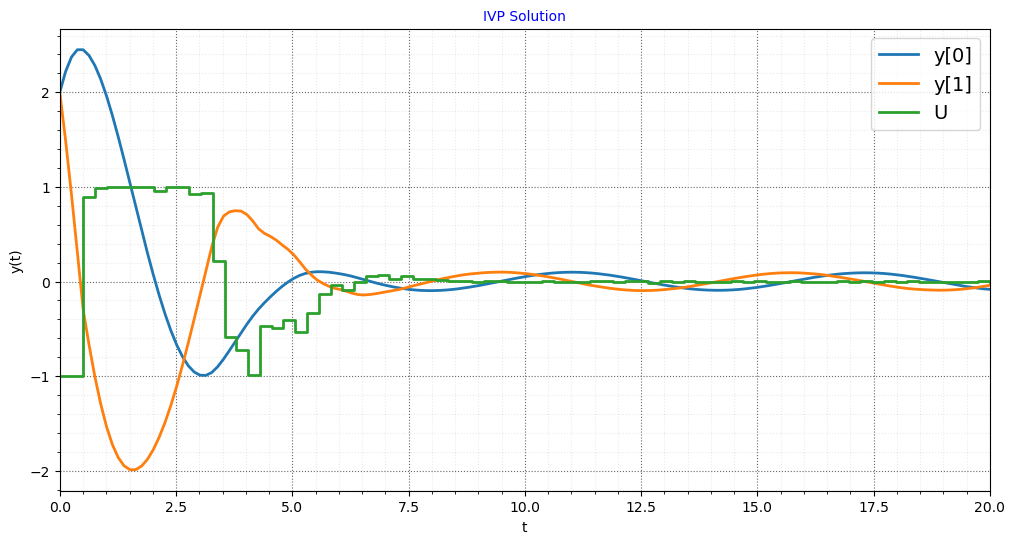

In [25]:
plt.figure(figsize = (12,6))
plt.plot(t_sim, sim.y[0,:],label='y[0]')
plt.plot(t_sim, sim.y[1,:],label='y[1]')
plt.step(t_MPC,Ustore,label='U',where='post')
plt.xlabel('t')
plt.legend()
plt.ylabel('y(t)')
plt.legend(fontsize=14)

plt.title('IVP Solution')
plt.xlim([min(t_sim),max(t_sim)])
nicegrid()